In [3]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import json
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

## Read data

In [4]:
def build_df(neg_file, pos_file):
    # read csv
    neg_df = pd.read_csv(neg_file)
    pos_df = pd.read_csv(pos_file)

    pos_df["label"] = 1
    neg_df["label"] = 0

    df = pd.concat([pos_df, neg_df])

    # drop columns with a single value
    unique_columns = df.columns[df.nunique() == 1]
    df.drop(unique_columns, axis=1, inplace=True)

    # drop unique columns and version columns (they will vary over time)
    df.drop(["hash", "PackageName", "min_andrversion", "max_andrversion", "target_andrversion"], axis=1, inplace=True)

    return df

We drop columns that have unique values in each row, as well as columns with a single value, since they are not discriminative. We also drop columns related to versions, since they won't extrapolate across time.

In [5]:
df = build_df("2000_goodware_2018_2020_features.csv", "2000_malware_2018_2020_features.csv")

Let's split the data in train and test:

In [6]:
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Tuning hyperparameters

Note: since the dataset is balanced we can use accuracy as a valid metric.

In [6]:
from sklearn.metrics import make_scorer, confusion_matrix

def custom_scoring(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    weight = 4.
    total = weight * fn + fn + tn + tp
    return 1. - (weight * fn + fp) / total

scorer = make_scorer(custom_scoring, greater_is_better=True)

In [58]:
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
    }

    # Create the XGBoost classifier with the hyperparameters
    classifier = XGBClassifier(**params)

    # Perform cross-validation
    scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=scorer)

    # Return the mean accuracy score as the objective value
    return scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Get the best hyperparameters and objective value
best_params = study.best_params
best_score = study.best_value

# Print the best hyperparameters and objective value
print("Best Hyperparameters:", best_params)
print("Best Objective Value:", best_score)


[I 2024-03-19 17:53:08,421] A new study created in memory with name: no-name-bcc8c7fa-a0dd-469b-95e6-91ce9d4097b1
[I 2024-03-19 17:53:10,249] Trial 0 finished with value: 0.9259582571601163 and parameters: {'n_estimators': 118, 'max_depth': 4, 'learning_rate': 0.05053588924071341, 'subsample': 0.8208441597725854, 'colsample_bytree': 0.8246245895790865, 'gamma': 0.048067763157043863, 'reg_alpha': 1.546219952371236, 'reg_lambda': 6.384652975671045, 'scale_pos_weight': 34.76636381704597}. Best is trial 0 with value: 0.9259582571601163.
[I 2024-03-19 17:53:12,369] Trial 1 finished with value: 0.8687091891185416 and parameters: {'n_estimators': 103, 'max_depth': 13, 'learning_rate': 0.010492256528442215, 'subsample': 0.9295885000368971, 'colsample_bytree': 0.9210671082170123, 'gamma': 0.0581097033248793, 'reg_alpha': 2.4450706386043732, 'reg_lambda': 5.070410423734588, 'scale_pos_weight': 49.691292693793514}. Best is trial 0 with value: 0.9259582571601163.
[I 2024-03-19 17:53:14,560] Trial 

Best Hyperparameters: {'n_estimators': 159, 'max_depth': 10, 'learning_rate': 0.09290916417838134, 'subsample': 0.5485049318989382, 'colsample_bytree': 0.5692934819801058, 'gamma': 0.9652107995700699, 'reg_alpha': 0.26089588047315754, 'reg_lambda': 1.457562658785509, 'scale_pos_weight': 7.46902794103935}
Best Objective Value: 0.9559027862070788


```python
best_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.09254019117978263,
    'subsample': 0.8971558521354843,
    'colsample_bytree': 0.5914997101665357,
    'gamma': 0.2789241965723543,
    'reg_alpha': 0.09006655234007827,
    'reg_lambda': 0.23580504543090375
}
```

## Evaluate the model

In [59]:
clf = XGBClassifier(**best_params)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5692934819801058, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.9652107995700699,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09290916417838134,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=159, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
print(json.dumps(report, indent=4))

{
    "0": {
        "precision": 0.9692307692307692,
        "recall": 0.9742268041237113,
        "f1-score": 0.9717223650385604,
        "support": 194.0
    },
    "1": {
        "precision": 0.975609756097561,
        "recall": 0.970873786407767,
        "f1-score": 0.97323600973236,
        "support": 206.0
    },
    "accuracy": 0.9725,
    "macro avg": {
        "precision": 0.9724202626641651,
        "recall": 0.9725502952657392,
        "f1-score": 0.9724791873854601,
        "support": 400.0
    },
    "weighted avg": {
        "precision": 0.9725159474671671,
        "recall": 0.9725,
        "f1-score": 0.9725018920558671,
        "support": 400.0
    }
}


In [61]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix / confusion_matrix.sum().sum() * 100

Predicted,0,1
Actual,,
0,47.25,1.25
1,1.50,50.00


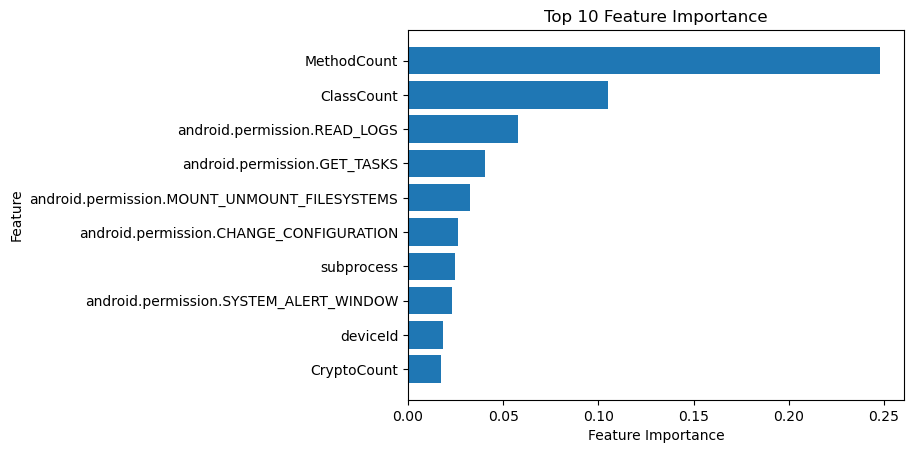

In [12]:
# Get the feature importance from the trained classifier
feature_importance = clf.feature_importances_

# Get the indices of the top 10 features
top_10_indices = feature_importance.argsort()[-10:]

# Get the names of the top 10 features
top_10_features = X.columns[top_10_indices]

# Get the importance values of the top 10 features
top_10_importance = feature_importance[top_10_indices]

# Create a bar plot of the top 10 features and their importance values
plt.barh(top_10_features, top_10_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()


In [13]:
# Get the positive and negative examples
positive_examples = df[df['label'] == 1]
negative_examples = df[df['label'] == 0]

# Get the values of the most important features
most_important_features = top_10_features.tolist()
binary_features = [feature for feature in most_important_features if len(df[feature].unique()) == 2]
numeric_features = [feature for feature in most_important_features if feature not in binary_features]

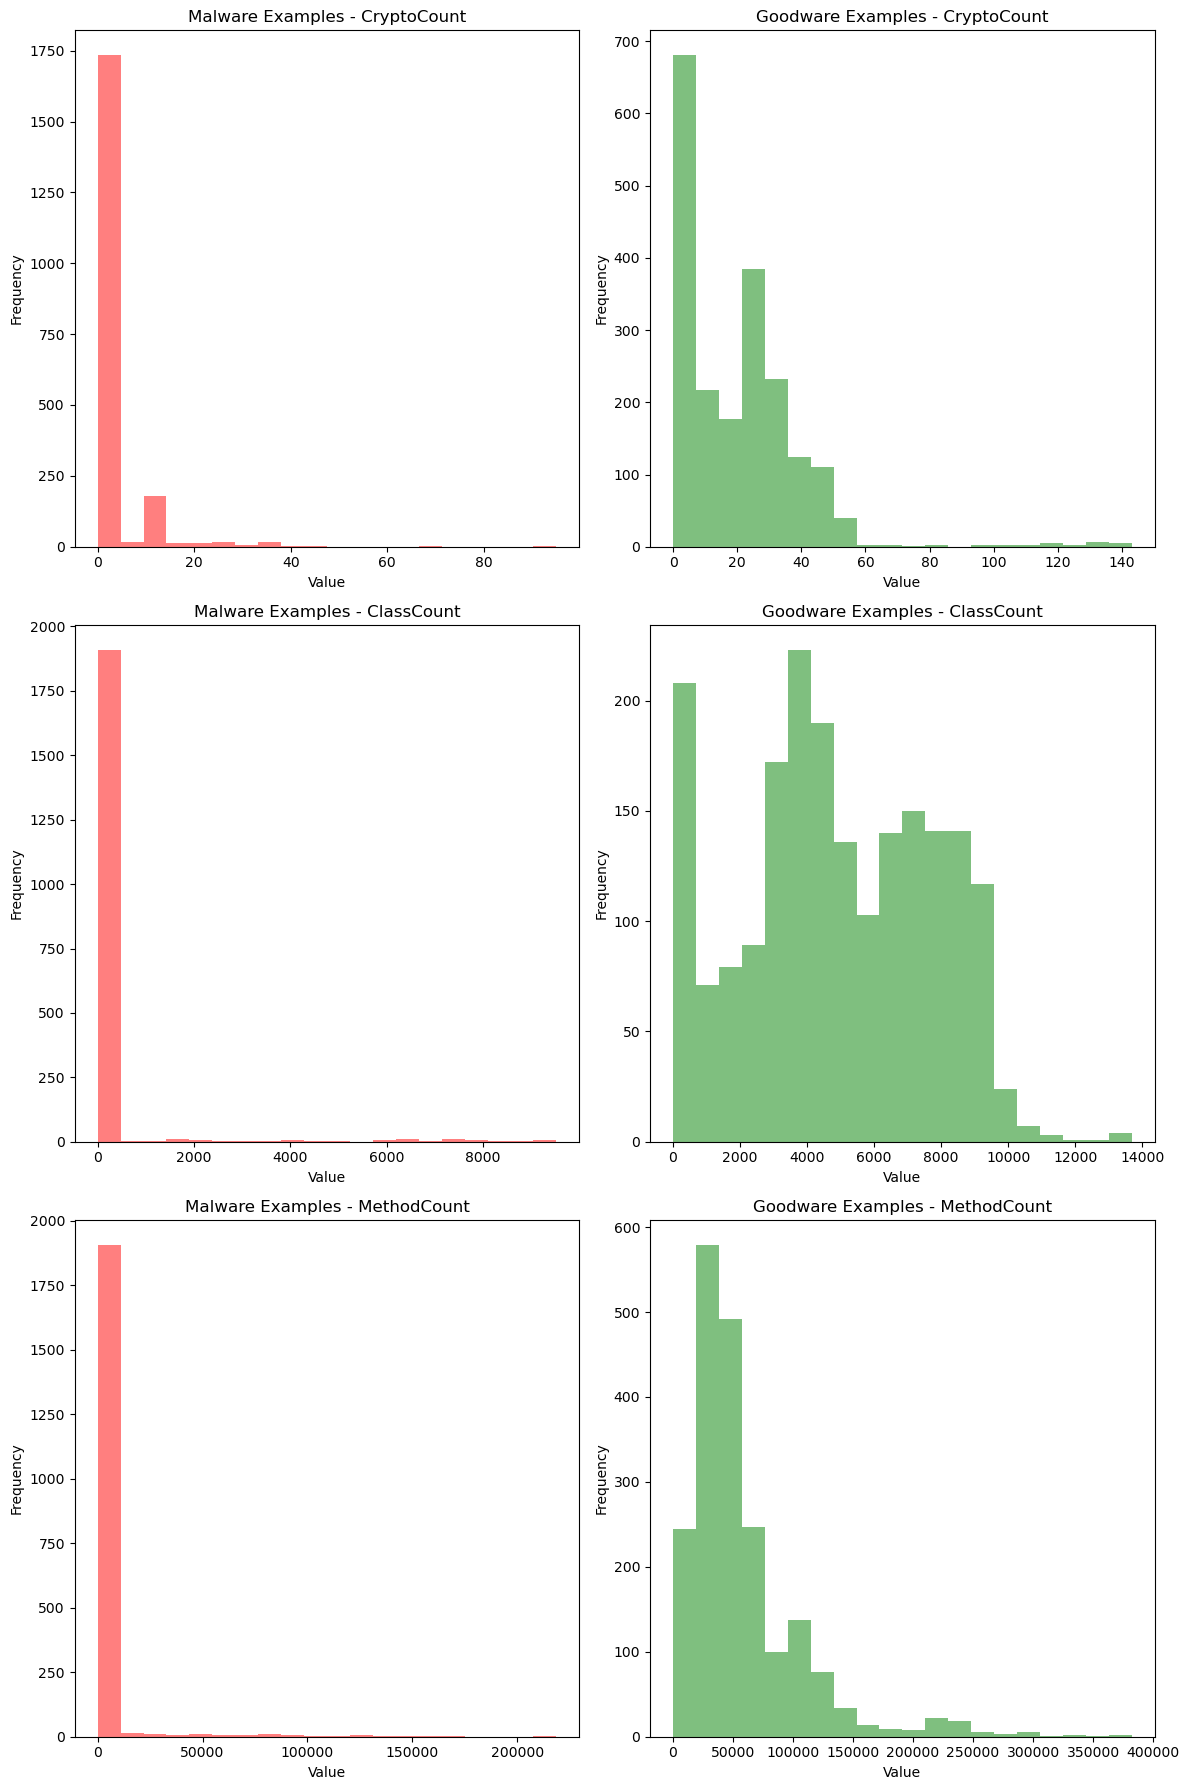

In [14]:
# Plot the distribution of the variables for both positive and negative examples
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=2, figsize=(12, 6 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    # Plot the distribution for positive examples
    axes[i, 0].hist(positive_examples[feature], bins=20, color='red', alpha=0.5)
    axes[i, 0].set_title(f'Malware Examples - {feature}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')

    # Plot the distribution for negative examples
    axes[i, 1].hist(negative_examples[feature], bins=20, color='green', alpha=0.5)
    axes[i, 1].set_title(f'Goodware Examples - {feature}')
    axes[i, 1].set_xlabel('Value')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

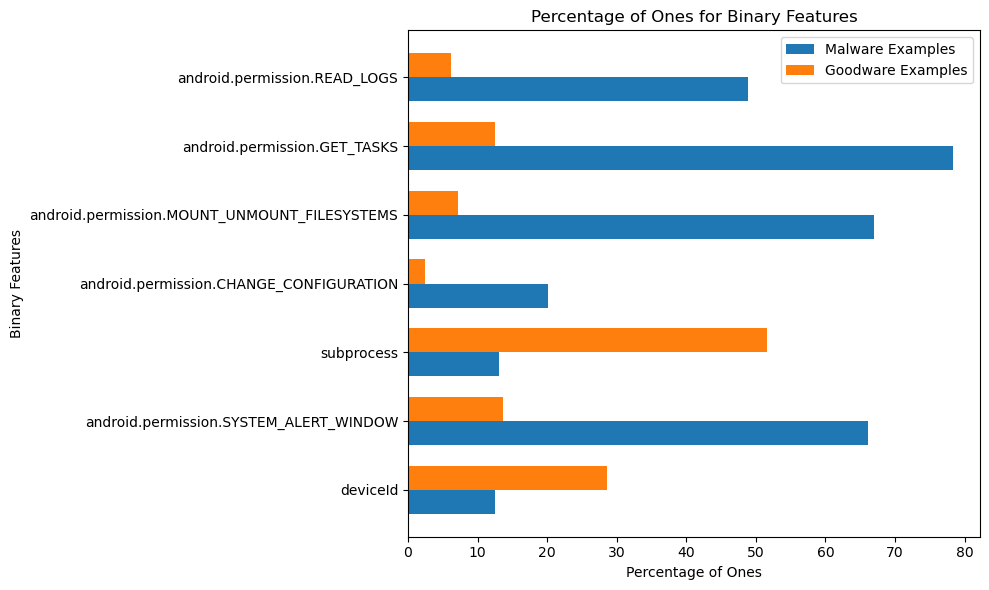

In [15]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
y = range(len(binary_features))
height = 0.35

# Calculate the percentage of ones for each binary feature in positive examples
positive_percentages = []
for feature in binary_features:
    positive_percentages.append(positive_examples[feature].mean() * 100)

# Calculate the percentage of ones for each binary feature in negative examples
negative_percentages = []
for feature in binary_features:
    negative_percentages.append(negative_examples[feature].mean() * 100)

# Plot the bar plots side by side
ax.barh(y, positive_percentages, height, label='Malware Examples')
ax.barh([i + height for i in y], negative_percentages, height, label='Goodware Examples')

# Set the labels, title, and ticks
ax.set_ylabel('Binary Features')
ax.set_xlabel('Percentage of Ones')
ax.set_title('Percentage of Ones for Binary Features')
ax.set_yticks([i + height/2 for i in y])
ax.set_yticklabels(binary_features)
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()
